# Load Libraries


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np

# Define U-Net model
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder1 = DoubleConv(3, 64)
        self.encoder2 = DoubleConv(64, 128)
        self.encoder3 = DoubleConv(128, 256)
        self.encoder4 = DoubleConv(256, 512)

        self.bottleneck = DoubleConv(512, 1024)

        self.decoder1 = DoubleConv(1024, 512)
        self.decoder2 = DoubleConv(512, 256)
        self.decoder3 = DoubleConv(256, 128)
        self.decoder4 = DoubleConv(128, 64)

        self.final_layer = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(nn.MaxPool2d(2)(enc1))
        enc3 = self.encoder3(nn.MaxPool2d(2)(enc2))
        enc4 = self.encoder4(nn.MaxPool2d(2)(enc3))

        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))

        dec1 = self.decoder1(nn.Upsample(scale_factor=0.5)(bottleneck))  # Reduce scale
        dec2 = self.decoder2(nn.Upsample(scale_factor=0.5)(dec1))
        dec3 = self.decoder3(nn.Upsample(scale_factor=0.5)(dec2))
        dec4 = self.decoder4(nn.Upsample(scale_factor=0.5)(dec3))
        output = nn.Upsample(size=(512, 512), mode="bilinear", align_corners=False)(dec4)
        output = self.final_layer(output)   # Ensure final size: 512x512

        return output

In [4]:
class KvasirDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

transform = transforms.Compose([
    transforms.Pad((50, 50, 50, 50), fill=0),  # Example padding to make images square
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])


dataset = KvasirDataset("Kvasir-SEG/images", "Kvasir-SEG/masks", transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

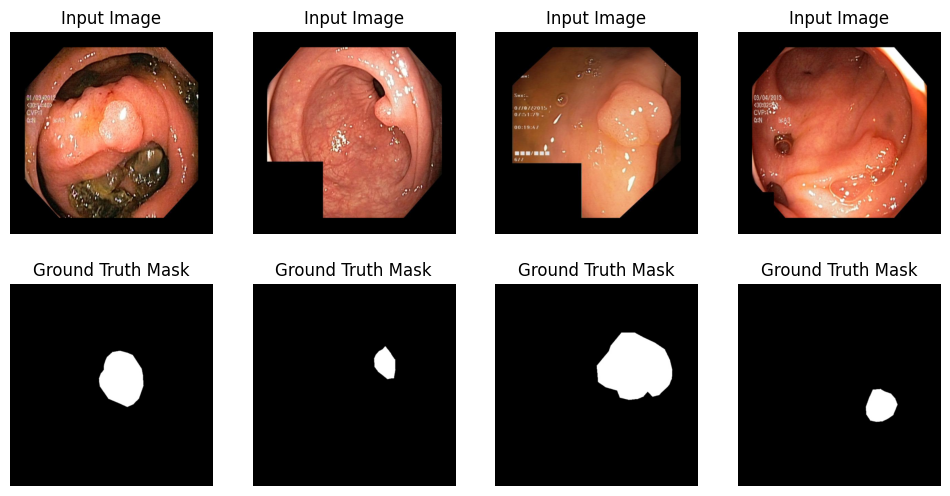

In [5]:
import random

def show_random_samples(dataset, num_samples=4):
    fig, ax = plt.subplots(2, num_samples, figsize=(12, 6))  # 2 Rows: Images & Masks

    indices = random.sample(range(len(dataset)), num_samples)  # Pick random indices

    for i, idx in enumerate(indices):
        image, mask = dataset[idx]  # Get image & mask pair

        ax[0, i].imshow(image.permute(1, 2, 0))  # Convert tensor to RGB format
        ax[0, i].set_title("Input Image")
        ax[0, i].axis("off")

        ax[1, i].imshow(mask.squeeze(), cmap="gray")  # Show mask in grayscale
        ax[1, i].set_title("Ground Truth Mask")
        ax[1, i].axis("off")

    plt.show()

# Call function to visualize dataset samples
show_random_samples(dataset)

In [6]:
device = torch.device("cuda")
model = UNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, dataloader, epochs=5):
    model.train()
    for epoch in range(epochs):
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

train(model, dataloader)

Epoch 1/5, Loss: 0.3054249882698059
Epoch 2/5, Loss: 0.26944631338119507
Epoch 3/5, Loss: 0.3555559515953064
Epoch 4/5, Loss: 0.3173633813858032
Epoch 5/5, Loss: 0.18716980516910553


In [7]:
import torch
import torch.nn.functional as F

def dice_coefficient(preds, masks, threshold=0.5):
    """Computes Dice Coefficient."""
    preds = (preds > threshold).float()  # Convert probabilities to binary (0 or 1)
    intersection = (preds * masks).sum()
    union = preds.sum() + masks.sum()
    dice = (2.0 * intersection) / (union + 1e-6)  # Adding small epsilon to prevent division by zero
    return dice.item()

def iou_score(preds, masks, threshold=0.5):
    """Computes Intersection over Union (IoU)."""
    preds = (preds > threshold).float()
    intersection = (preds * masks).sum()
    union = preds.sum() + masks.sum() - intersection
    iou = intersection / (union + 1e-6)
    return iou.item()

In [8]:
def evaluate_unet(model, dataloader, device):
    model.eval()
    total_accuracy, total_dice, total_iou = 0, 0, 0
    num_samples = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)

            # Compute Metrics
            dice = dice_coefficient(preds, masks)
            iou = iou_score(preds, masks)
            accuracy = torch.sum((preds > 0.5) == masks).item() / (masks.numel())

            # Accumulate Results
            total_dice += dice
            total_iou += iou
            total_accuracy += accuracy
            num_samples += 1

    print(f"Average Dice Coefficient: {total_dice / num_samples:.4f}")
    print(f"Average IoU Score: {total_iou / num_samples:.4f}")
    print(f"Average Accuracy: {total_accuracy / num_samples:.4f}")

# Run Evaluation
evaluate_unet(model, dataloader, device)

Average Dice Coefficient: 0.0000
Average IoU Score: 0.0000
Average Accuracy: 0.8829


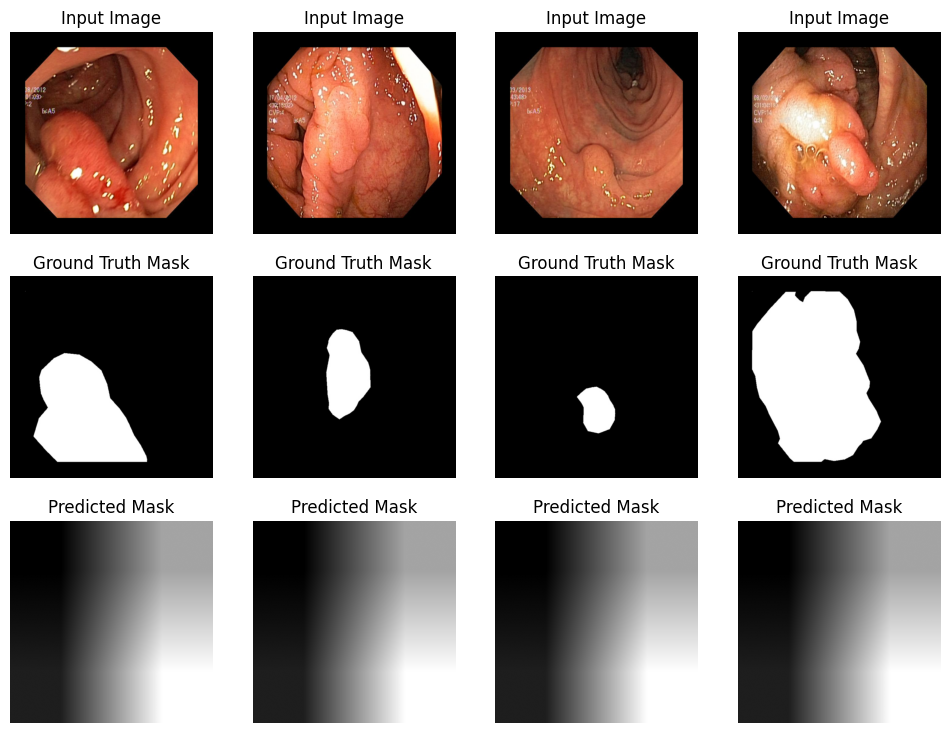

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Ensure the model is moved to the correct device

def predict_and_visualize(model, dataloader, device):
    model.eval()  # Set to evaluation mode
    with torch.no_grad():  # Disable gradient tracking
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)  # Move tensors to the correct device
            outputs = model(images)

            fig, ax = plt.subplots(3, 4, figsize=(12, 9))  # 3 Rows: Input, Ground Truth, Prediction

            for i in range(4):  # Visualizing 4 images at a time
                ax[0, i].imshow(images[i].cpu().permute(1, 2, 0))  # Move back to CPU for plotting
                ax[0, i].set_title("Input Image")
                ax[0, i].axis("off")

                ax[1, i].imshow(masks[i].cpu().squeeze(), cmap="gray")
                ax[1, i].set_title("Ground Truth Mask")
                ax[1, i].axis("off")

                ax[2, i].imshow(outputs[i].cpu().squeeze(), cmap="gray")  # Move predictions to CPU
                ax[2, i].set_title("Predicted Mask")
                ax[2, i].axis("off")

            plt.show()
            break  # Show only the first batch

# Call the function with the correct device
predict_and_visualize(model, dataloader, device)